In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMPORTS

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel,pipeline
import re
import nltk
from nltk.corpus import stopwords

In [56]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Seif
[nltk_data]     Yasser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
BATCH_SIZE=1 #16
LR=0.0002
BETAS=(0.5,0.999)
NUM_EPOCHS=10
z_dim=200

# Text Preprocessing

In [3]:
def preprocessing(label):
    
    stop_words = set(stopwords.words('english'))
    cleaned_string = re.sub(r'\d+', '', label) 
    cleaned_string = re.sub(r'[^\w\s]', '', cleaned_string).lower()  
    cleaned_string = cleaned_string.replace('_', ' ')  
   
    words = cleaned_string.split()  
    cleaned_string = " ".join([word for word in words if word not in stop_words]) 
    return cleaned_string

In [4]:
# Initialize the BERT pipeline for feature extraction
embedder = pipeline('feature-extraction', model='bert-base-uncased', tokenizer='bert-base-uncased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [5]:
# Define a function to get BERT embeddings
def get_bert_embedding(caption):
    embedding = embedder(caption)
    mean_embedding = np.mean(embedding[0], axis=0)
    return mean_embedding

In [57]:
x="This is seif"
get_bert_embedding(preprocessing(x))

array([ 2.29876488e-03,  6.60924539e-02, -7.69184329e-01, -3.59305538e-01,
       -4.29855598e-01, -2.61099521e-01,  2.12720189e-01, -3.61880437e-02,
        3.27633422e-01, -4.25100898e-01, -2.34150581e-01, -2.62479242e-02,
        6.50410168e-03,  1.45595144e-01, -3.02179039e-01, -6.77112788e-02,
       -5.06543312e-02, -2.71102119e-01,  4.64054745e-01, -1.43851187e-01,
       -2.95604937e-01, -1.86969046e-01,  9.79895648e-02, -3.25841464e-01,
        1.74450073e-02, -1.45981319e-01,  9.68866087e-02,  2.58709852e-01,
       -7.81957973e-02,  1.06812753e-01, -3.13755546e-01, -5.26639111e-02,
       -3.07158079e-01, -4.99235839e-02, -2.25145927e-01, -3.34745655e-02,
       -7.74697401e-03,  7.74308369e-02,  4.55577672e-02,  3.13524902e-03,
       -1.00801580e-01, -3.27707417e-01, -2.04910514e-01,  1.04286894e-02,
        1.74564887e-02, -5.01414329e-01, -2.18489408e-01,  2.19651564e-01,
        2.65882015e-02,  3.55904579e-01, -3.24901734e-01,  2.93588512e-01,
       -3.16817062e-01, -

In [ ]:
# !pip install torchfile
# import os
# import torchfile

# # Path to the folder containing the .t7 files
# t7_folder_path = '/kaggle/input/cub2002011/cvpr2016_cub/w2v_c10'

# # List all .t7 files in the folder
# t7_files = [f for f in os.listdir(t7_folder_path) if f.endswith('.t7')]

# # Loop through each .t7 file and load it
# for t7_file in t7_files:
#     t7_file_path = os.path.join(t7_folder_path, t7_file)
    
#     # Load the .t7 file
#     t7_data = torchfile.load(t7_file_path)
    
#     # Print the name of the file and the data
#     print(f"File: {t7_file}")
#     print("Data:", t7_data)

# print(t7_data.shape)
# print(t7_data[1][0])

# Dataset Class

In [227]:
class CUBTextImageDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        base_name = os.path.splitext(image_file)[0]
        txt_path = os.path.join(self.text_dir, base_name + ".txt")
        with open(txt_path, 'r') as file:
            txt_description = file.read().strip()
        return image, txt_description


In [307]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [308]:
image_dir = 'segmented_images1/001.Black_footed_Albatross/'
text_dir = 'text_c10/001.Black_footed_Albatross/'

In [309]:
dataset = CUBTextImageDataset(image_dir=image_dir, text_dir=text_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [10]:
# dataset

In [233]:
for img, txt in dataloader:
    print(img.shape)
    print(get_bert_embedding(preprocessing(txt[0])).__len__())
    print(txt[0])
    break

torch.Size([1, 3, 128, 128])
768
bird with large wingspan, very long and thick downward curved beak.
a large bird with large black wings, a gray body, and large hooked gray beak.
this is a bird with a white belly and dark wings.
this bird has very wide-reacing wingbars and secondaries. the breast is white and it has a dark yellow bill.
this is a large bird with large secondaries and white on the cheek patches.
a large bird with a grey belly, and large black wings.
this bird is grey with black and has a long, pointy beak.
this pale black bird has two wide spread wingbars and throat and beak are light in color
this bird has a black crown, black primaries, and a black belly.
this large majestic bird has a huge wingspan that is mostly black and gray while its bill is white and the body is mostly gray.


In [11]:
def get_noise(BATCH_SIZE, z_dim, device='cpu'):
    return torch.randn(BATCH_SIZE, z_dim,1,1).to(device) 

In [157]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [40]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image, cmap='gray')
#         axes[i].set_title(image_filename, fontsize=8)

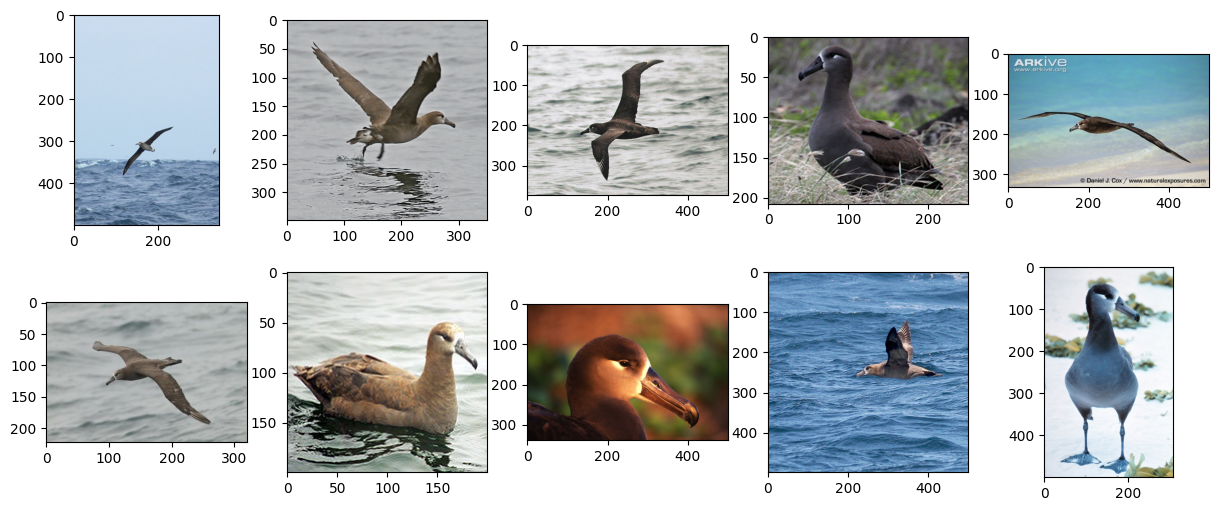

In [41]:
Black_footed_Albatross_dir='/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross'
# visualize_images(Black_footed_Albatross_dir)

# Architecture

## Generator

In [310]:
class Generator(nn.Module):
    def __init__(self,embed_size=128,z_dim=100,im_chan=3,hidden_dim=64,num_classes=2):
        super(Generator,self).__init__()
        self.z_dim=z_dim
        self.initial_layer = nn.Linear(z_dim, hidden_dim * 16 * 4 * 4)
        self.gen=nn.Sequential(
            nn.ConvTranspose2d(z_dim+embed_size,hidden_dim*8,4,1,0),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*8,hidden_dim*8,4,2,1),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*8,hidden_dim*4,4,2,1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*4,hidden_dim*2,4,2,1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*2,hidden_dim,4,2,1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim,3,4,2,1),
#             nn.BatchNorm2d(hidden_dim*2),
#             nn.ReLU(inplace=True),
            nn.Tanh(),
#             nn.Embedding()
        )
        self.embedding = nn.Embedding(num_classes, embed_size)
        self.linear=nn.Linear(768,embed_size)
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    
    def forward(self,x,labels):
        labels=self.linear(labels)
        embeddings=labels.unsqueeze(2).unsqueeze(3)
        # print(embeddings.shape)
        x=torch.cat([x,embeddings],dim=1)
        # print(x.shape)
#         x = self.initial_layer(x)
#         x = x.view(x.size(0), -1, 4, 4)
        return self.gen(x)

In [ ]:
# # -- Load the .t7 model
# # model = torch.load('pretrained.t7')
# import torchfile

# # Load the .t7 file
# discriminator_data = torchfile.load('pretrained.t7')

# # The discriminator_data will contain the weights and biases of your model
# print(discriminator_data)


In [9]:
gen=Generator()

### Testing Gen

In [311]:
gen=Generator()

In [312]:
embed=torch.rand(1,768)
img=torch.rand(1,100,1,1)
gen(img,embed).shape

torch.Size([1, 3, 128, 128])

## Discriminator

In [332]:
class Concat_embed(nn.Module):
    def __init__(self, embed_dim=768, projected_embed_dim=128):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=768, out_features=128),
            nn.Identity(),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        # print(replicated_embed.shape)
        # print(inp.shape)

        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat


In [333]:
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()
		self.image_size = 128
		self.num_channels = 3
		self.embed_dim = 768
		self.projected_embed_dim = 128
		self.ndf = 64
		self.B_dim = 128
		self.C_dim = 16

		self.netD_1 = nn.Sequential(
			# input is (nc) x 64 x 64
			nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf) x 32 x 32
			nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 2),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*2) x 16 x 16
			nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 4),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*4) x 8 x 8
			nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 8),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Conv2d(self.ndf * 8, self.ndf * 8, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 8),
			nn.LeakyReLU(0.2, inplace=True),
		)

		self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

		self.netD_2 = nn.Sequential(
			# state size. (ndf*8) x 4 x 4
			nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
			nn.Sigmoid()
			)	

	def forward(self, inp, embed):
		x_intermediate = self.netD_1(inp)
		x = self.projector(x_intermediate, embed)
		x = self.netD_2(x)

		return x.view(-1, 1).squeeze(1) , x_intermediate

### Testing Disc

In [320]:
disc=Discriminator()
embed=torch.rand(1,768)
img=torch.rand(1,3,128,128)
disc(img,embed)[0].shape

torch.Size([1, 128, 4, 4])
torch.Size([1, 512, 4, 4])


torch.Size([1])

# Text Embedding

In [29]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    for i in range(10):
        print("Batch of Images:", images.shape)
        print("Batch of Text Descriptions: ", descriptions[0].split('\n')[i])
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has a very noticeable black crown, nape and cheek patch while its eyebrow is starkwhite, it has a short, black beak and mottled yellow wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird is brown with a white chest and has a very short beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small bird has a black head with a white eyepatch and white throat.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this is a small, white bird with a black crown and brown wingbars.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small white bird has a black head and yellow and black wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  the small bird has a black crown with a white belly
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions: 

In [14]:
text=descriptions[0].split('\n')[0]

In [17]:
test_df=pd.DataFrame(descriptions[0].split('\n'))

In [20]:
# # Assign the embeddings to a new column in the sampled dataframe
test_df['vector'] = test_df[0].apply(lambda x: get_bert_embedding(x))
test_df.head()

,0,vector
0,"a white bird with webbed feet, an orange beak ...","[-0.014718351065225545, -0.05030688155619871, ..."
1,"a large bird with an expansive wing span, that...","[-0.1399901636847944, 0.04223645486953584, -0...."
2,"this bird has a wide wingspan, a long orange b...","[-0.04294362664222717, 0.2631648364274398, -0...."
3,"this bird has a bright orange bill, a light gr...","[-0.0761377125684368, 0.17957989935223995, -0...."
4,this seagull has white feathers and a small or...,"[-0.25227072884639107, 0.11543269527610392, -0..."


In [37]:
test_df['vector'].iloc[0].shape

(768,)

In [35]:
test_df[0].iloc[1].split(' ').__len__()

29

In [334]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [335]:
gen=Generator().to(device)
disc=Discriminator().to(device)

In [336]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [337]:
gen.apply(weights_init)
disc.apply(weights_init)

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05

In [338]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)

In [339]:
criterion=nn.BCELoss()
l1_loss=nn.L1Loss()
l2_loss=nn.MSELoss()

In [340]:
gen.train()
disc.train()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05

In [341]:
cur_step=0
display_step=350
mean_generator_loss=0
mean_discriminator_loss=0

In [342]:
device

device(type='cuda')

In [343]:
z_dim=100

In [346]:
generator_losses = []
discriminator_losses = []
start_epoch=130

# 10 + 120 + 170 epochs

In [ ]:
for epoch in range(170):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    cur_step = 0
    
    for img, label in tqdm(dataloader):
        batch_size = len(img)
        for j in range(batch_size):
            for i in range(10):
                description = label[j].split('\n')[i]
                description = preprocessing(description)
                embedding = get_bert_embedding(description)
                embedding = torch.from_numpy(embedding).unsqueeze(0).to(device).float()
                img = img.to(device).float()

                # Train Discriminator
                disc_opt.zero_grad()
                outputs, activation_real = disc(img, embedding)
                smoothed_real_labels = torch.ones_like(outputs) * 0.9
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                fake_noise = get_noise(batch_size, 100, device)
                fake_images = gen(fake_noise, embedding)
                outputs, _ = disc(fake_images, embedding)
                fake_loss = criterion(outputs, torch.zeros_like(outputs))
                fake_score = outputs

                d_loss = real_loss + fake_loss
                d_loss.backward()
                disc_opt.step()
                mean_discriminator_loss += d_loss.item() / display_step

                # Train Generator
                gen_opt.zero_grad()
                fake_noise_2 = get_noise(batch_size, 100, device)
                fake_2 = gen(fake_noise, embedding)
                outputs, activation_fake = disc(fake_2, embedding)
                _, activation_real = disc(img, embedding)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                g_loss = criterion(outputs, torch.ones_like(outputs)) + \
                         100 * l2_loss(activation_fake, activation_real.detach()) + \
                         50 * l1_loss(fake_2, img)

                g_loss.backward()
                gen_opt.step()
                mean_generator_loss += g_loss.item() / display_step

                if cur_step % display_step == 0 and cur_step > 0:
                    print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                    show_tensor_images(fake_images)
                    show_tensor_images(img)
                    mean_generator_loss = 0
                    mean_discriminator_loss = 0
                cur_step += 1
    
    # At the end of each epoch, save the mean losses
    generator_losses.append(mean_generator_loss / len(dataloader))
    discriminator_losses.append(mean_discriminator_loss / len(dataloader))
    
    # Plot every 50 epochs
    if (epoch + 1) % 50 == 0:
        epochs_range = range(start_epoch, start_epoch + len(generator_losses))
        plt.figure(figsize=(10, 5))
        plt.plot(epochs_range, generator_losses, label="Generator Loss")
        plt.plot(epochs_range, discriminator_losses, label="Discriminator Loss")
        plt.title(f"Losses at Epoch {epoch + 1 + start_epoch}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"Plots/losses_epoch_{epoch + 1 + start_epoch}.png")
        plt.show()
        # plt.show()

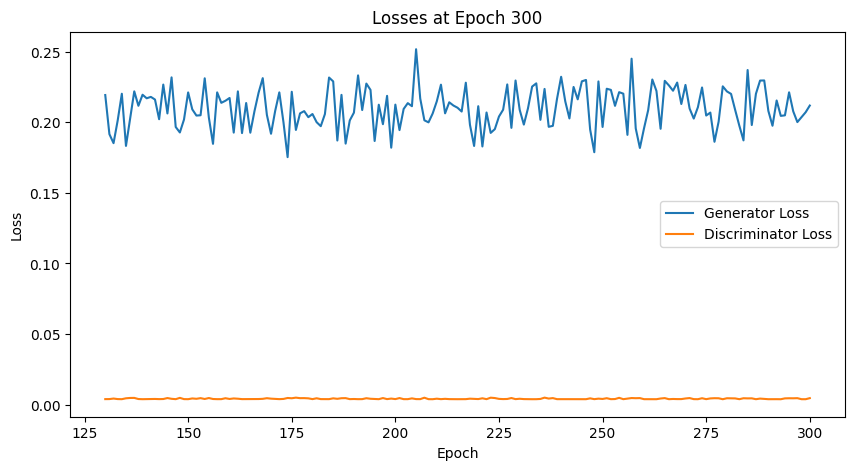

In [350]:
epochs_range = range(start_epoch, start_epoch + len(generator_losses))
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, generator_losses, label="Generator Loss")
plt.plot(epochs_range, discriminator_losses, label="Discriminator Loss")
plt.title(f"Losses at Epoch {epoch + 1 + start_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"Plots/losses_epoch_{epoch + 1 + start_epoch}.png")
plt.show()

In [351]:
# save the models
torch.save(gen.state_dict(), 'Models/gen_300.pth')
torch.save(disc.state_dict(), 'Models/disc_300.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


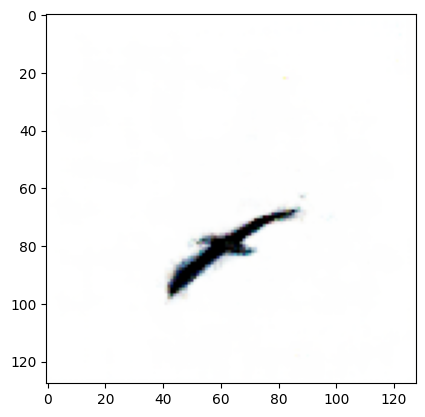

In [355]:
txt="this large bird has a buff colored belly, a long heavy beak on a white-fronted face , and long, dark brown wings."
txt=preprocessing(txt)
embedding = get_bert_embedding(txt)
embedding = torch.from_numpy(embedding).unsqueeze(0).to(device).float()
fake_noise = get_noise(1, 100, device)
fake_images = gen(fake_noise, embedding)
plt.imshow(fake_images[0].detach().cpu().permute(1, 2, 0).squeeze())

Step 73500: Generator loss: 20.75571266787393, discriminator loss: 0.3654655234302796


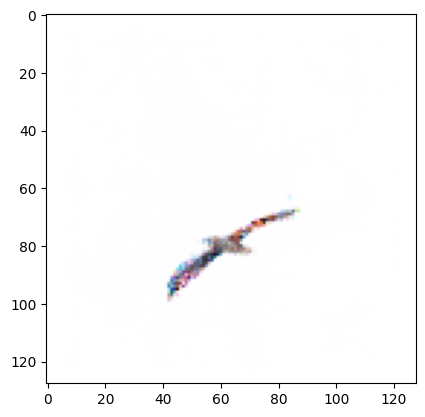

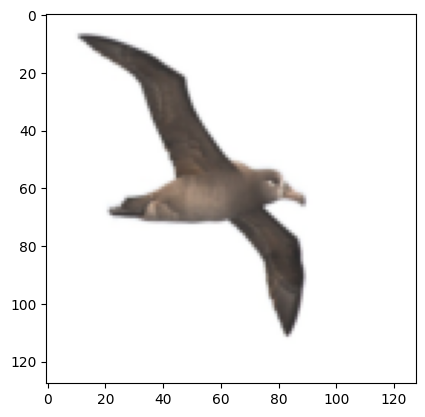

  0%|          | 0/60 [00:00<?, ?it/s]

Step 73850: Generator loss: 15.719552617754252, discriminator loss: 0.3326310264212744


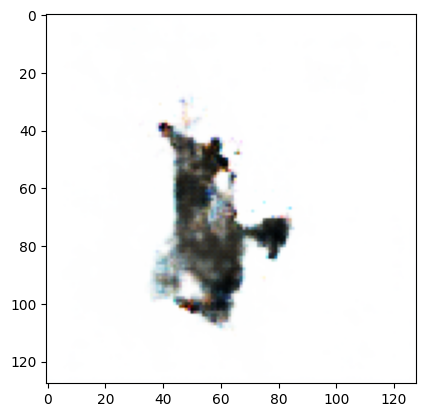

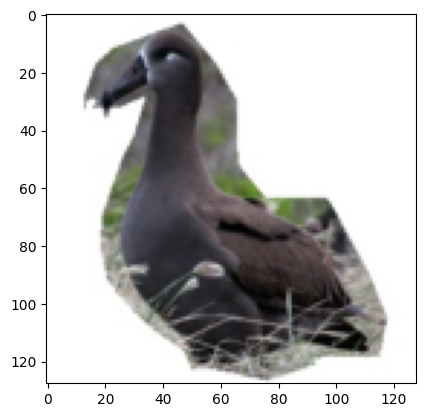

Step 74200: Generator loss: 16.98152658326286, discriminator loss: 0.34441312730312346


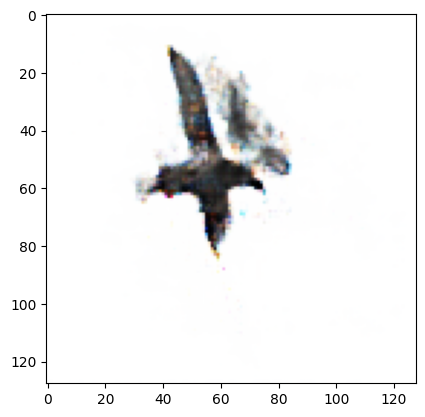

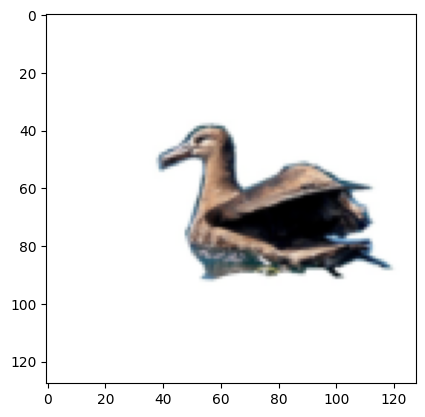

  0%|          | 0/60 [00:00<?, ?it/s]

Step 74550: Generator loss: 17.963223536355166, discriminator loss: 0.40301812112331387


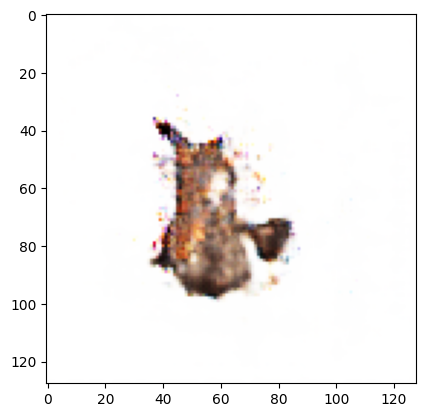

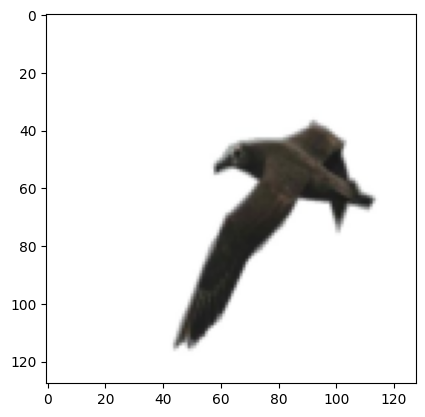

Step 74900: Generator loss: 15.650168518338884, discriminator loss: 0.3529813275166919


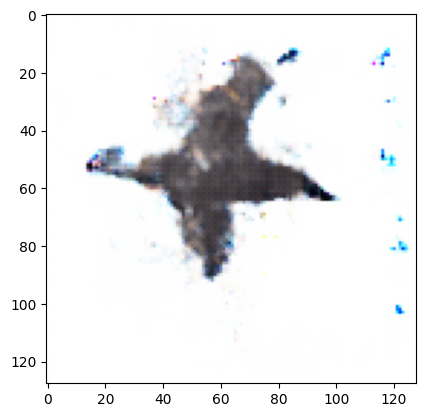

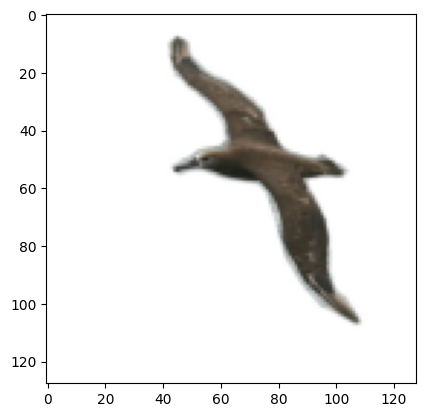

  0%|          | 0/60 [00:00<?, ?it/s]

Step 75250: Generator loss: 17.214156051363254, discriminator loss: 0.3752295125382284


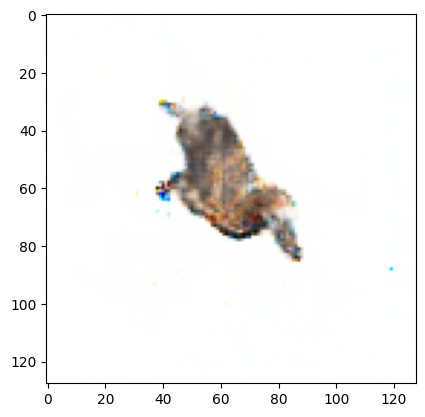

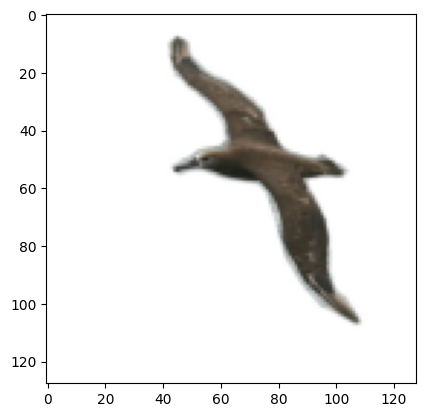

  0%|          | 0/60 [00:00<?, ?it/s]

Step 75600: Generator loss: 16.421291133335664, discriminator loss: 0.3849532814536777


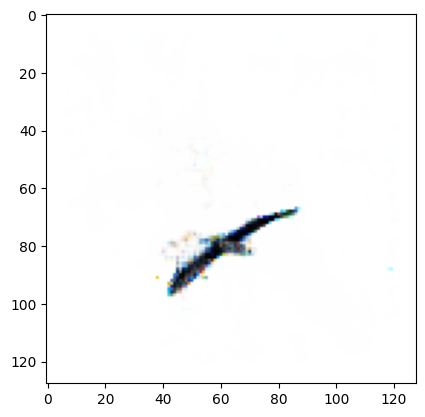

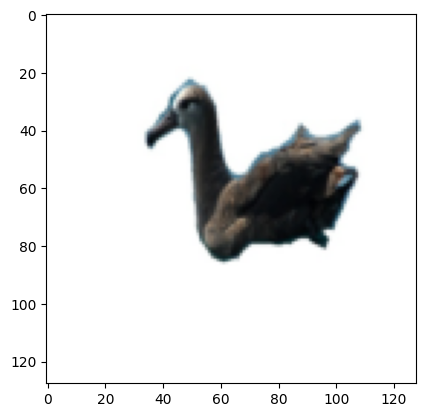

Step 75950: Generator loss: 17.110737699440527, discriminator loss: 0.38512457626206503


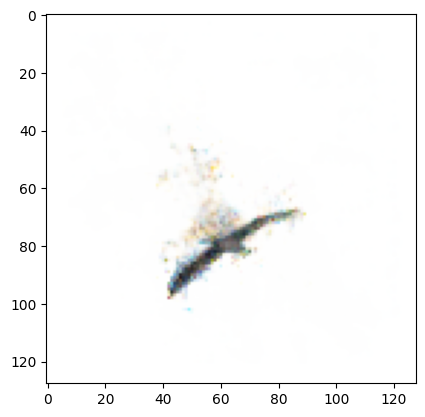

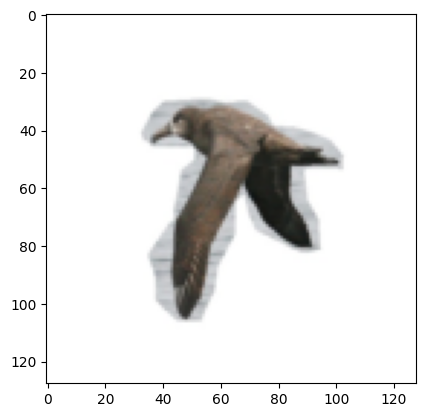

  0%|          | 0/60 [00:00<?, ?it/s]

Step 76300: Generator loss: 16.24964448656356, discriminator loss: 0.36320180390562345


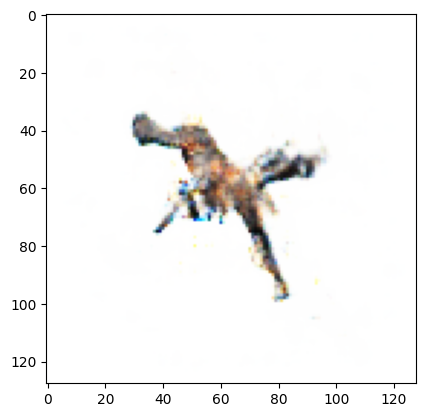

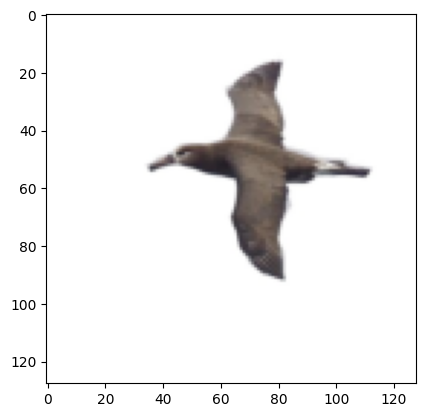

Step 76650: Generator loss: 16.902060303006838, discriminator loss: 0.38354472466877554


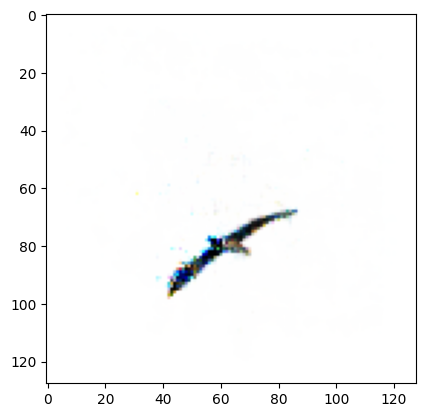

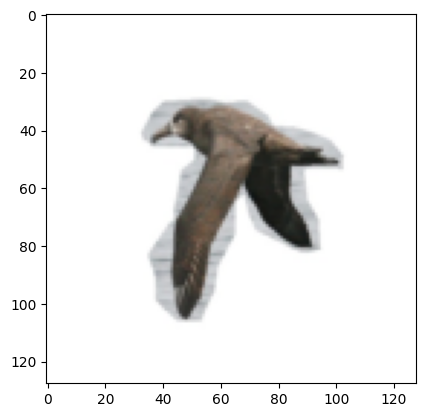

  0%|          | 0/60 [00:00<?, ?it/s]

Step 77000: Generator loss: 15.498066816244817, discriminator loss: 0.4063042363098688


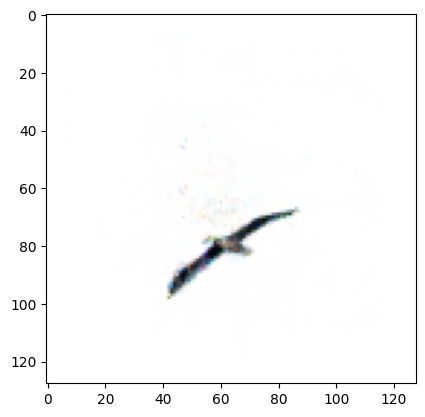

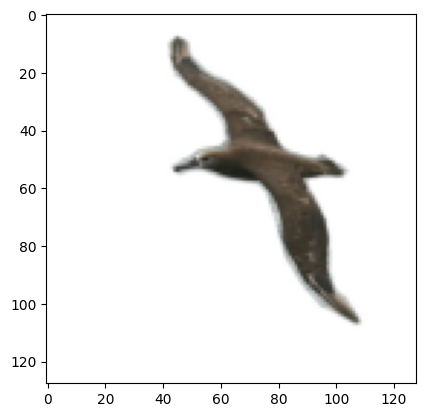

Step 77350: Generator loss: 18.432179010936185, discriminator loss: 0.3379309893505915


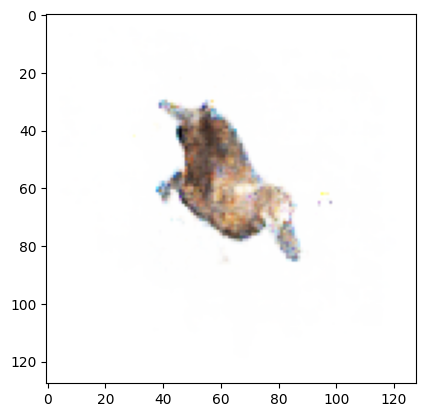

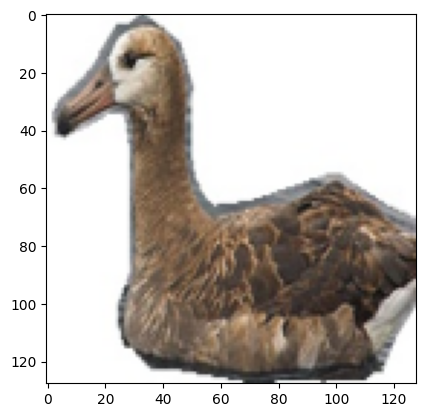

  0%|          | 0/60 [00:00<?, ?it/s]

Step 77700: Generator loss: 18.44840006692066, discriminator loss: 0.33075114403452194


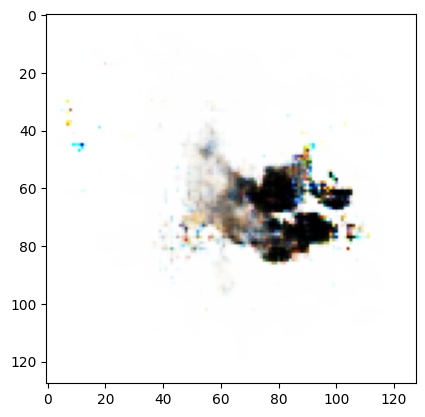

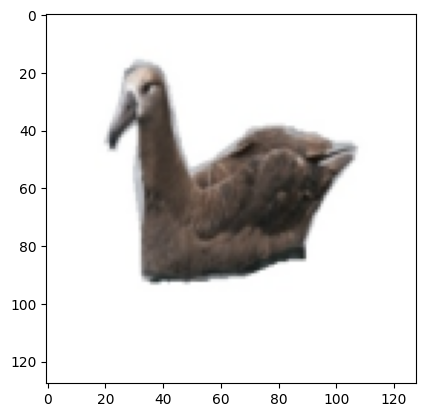

In [345]:
for epoch in range(170):
    for img,label in tqdm(dataloader):
        batch_size=len(img)
        for j in range(batch_size):
            for i in range(10):
                description=label[j].split('\n')[i]
                description=preprocessing(description)
                embedding=get_bert_embedding(description)
                embedding=torch.from_numpy(embedding).unsqueeze(0)
                embedding=embedding.to(device).to(torch.float32)
                img=img.to(device).to(torch.float32)
                #===========================================
                #======== Train Discriminator ==============
                #===========================================            
                disc_opt.zero_grad()
                outputs, activation_real = disc(img, embedding)
                smoothed_real_labels=torch.ones_like(outputs)*0.9
                real_loss=criterion(outputs,smoothed_real_labels)
                real_score=outputs

                fake_noise=get_noise(batch_size,100,device)
                fake_images=gen(fake_noise,embedding)
                outputs,_=disc(fake_images,embedding)
                fake_loss=criterion(outputs,torch.zeros_like(outputs))
                fake_score=outputs

                d_loss=real_loss+fake_loss

                d_loss.backward()
                disc_opt.step()
                mean_discriminator_loss+=d_loss.item()/display_step
                #===========================================
                #======== Train Generator ==================
                #===========================================
                gen_opt.zero_grad()
                fake_noise_2=get_noise(batch_size,100,device)
                fake_2=gen(fake_noise,embedding)
                outputs,activation_fake=disc(fake_2,embedding)
                _, activation_real=disc(img,embedding)

                activation_fake=torch.mean(activation_fake,0)
                activation_real=torch.mean(activation_real,0)
#                 print(outputs.shape)
#                 print(embedding.shape)
                
                g_loss=criterion(outputs,torch.ones_like(outputs))+100*l2_loss(activation_fake,activation_real.detach())+50*l1_loss(fake_2,img)

                g_loss.backward()
                gen_opt.step()
                mean_generator_loss+=g_loss.item()/display_step

                if cur_step % display_step == 0 and cur_step > 0:
                    print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                    show_tensor_images(fake_images)
                    show_tensor_images(img)
                    mean_generator_loss = 0
                    mean_discriminator_loss = 0
                cur_step += 1

In [193]:
from torch.autograd import Variable

In [183]:
generator=Generator().cuda()
discriminator=Discriminator().cuda()


In [184]:
optimG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))